In [3]:
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import RandAugment
from IPython.core.debugger import set_trace
import os

import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
from loss import PriorPreservationLoss

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model_id = "CompVis/stable-diffusion-v1-4"

In [7]:
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                torch_dtype=torch.float16,
                                                use_safetensors=True,
                                                variant="fp16")
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [8]:
folder_path = '/home/ahm247/dreambooth/dataset/dog6'
input_images = []
for filename in os.listdir(folder_path): 
    img = Image.open(os.path.join(folder_path, filename))
    input_images.append(img)

In [16]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(input_images[0]).to(torch.float16)
input_tensor = input_tensor.to(device)

pipe.vae(input_tensor.unsqueeze(0))

DecoderOutput(sample=tensor([[[[ 1.0508,  1.1709,  1.2305,  ...,  1.1943,  1.1250,  0.9585],
          [ 1.2168,  1.1660,  1.1660,  ...,  1.1816,  1.2178,  1.1924],
          [ 1.2637,  1.2236,  1.2344,  ...,  1.2373,  1.2559,  1.2100],
          ...,
          [ 1.3135,  1.3057,  1.2812,  ...,  1.2930,  1.3525,  1.2910],
          [ 1.3125,  1.2910,  1.3047,  ...,  1.3652,  1.3486,  1.2793],
          [ 1.1641,  1.3857,  1.3867,  ...,  1.3916,  1.3535,  1.1162]],

         [[-0.1179, -0.1761, -0.2196,  ..., -0.2290, -0.2325, -0.1085],
          [-0.1847, -0.1852, -0.2151,  ..., -0.2450, -0.1986, -0.1819],
          [-0.2063, -0.2292, -0.2146,  ..., -0.2292, -0.2003, -0.2489],
          ...,
          [-0.0132, -0.0384, -0.0482,  ..., -0.1714, -0.1987, -0.2236],
          [ 0.0093, -0.0370, -0.0293,  ..., -0.1658, -0.1597, -0.1469],
          [ 0.0765,  0.0208, -0.0045,  ..., -0.1006, -0.1074, -0.0078]],

         [[-0.6768, -0.8691, -0.8228,  ..., -0.8701, -0.8657, -0.7002],
         

In [7]:
prior_images = []
prompt = "A dog"
for i in range(5):
    prior_images.append(pipe(prompt=prompt).images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

In [9]:
folder_path = '/home/ahm247/dreambooth/dataset/dog6'
input_images = []
for filename in os.listdir(folder_path): 
    img = Image.open(os.path.join(folder_path, filename))
    input_images.append(img)
    
input_images = torch.stack([transform(image) for image in input_images])
prior_images = torch.stack([transform(image) for image in prior_images])

In [10]:
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr = 5e-6)

  0%|          | 0/50 [00:00<?, ?it/s]

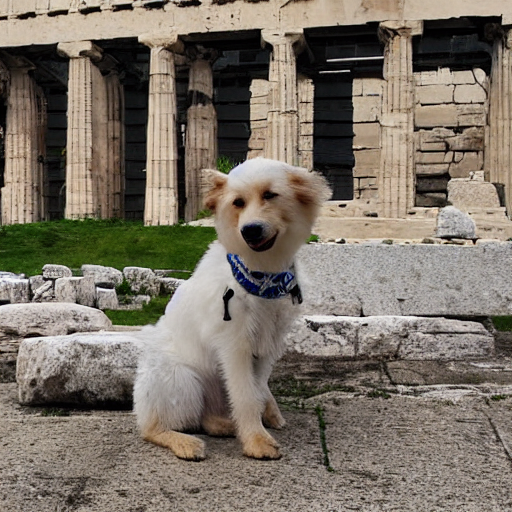

In [22]:
pipe(prompt='A sks dog at the Acropolis').images[0]

In [23]:
folder_path = '/home/ahm247/dreambooth/dataset/dog6'
input_images_color = []
for filename in os.listdir(folder_path): 
    img = Image.open(os.path.join(folder_path, filename))
    input_images_color.append(img)

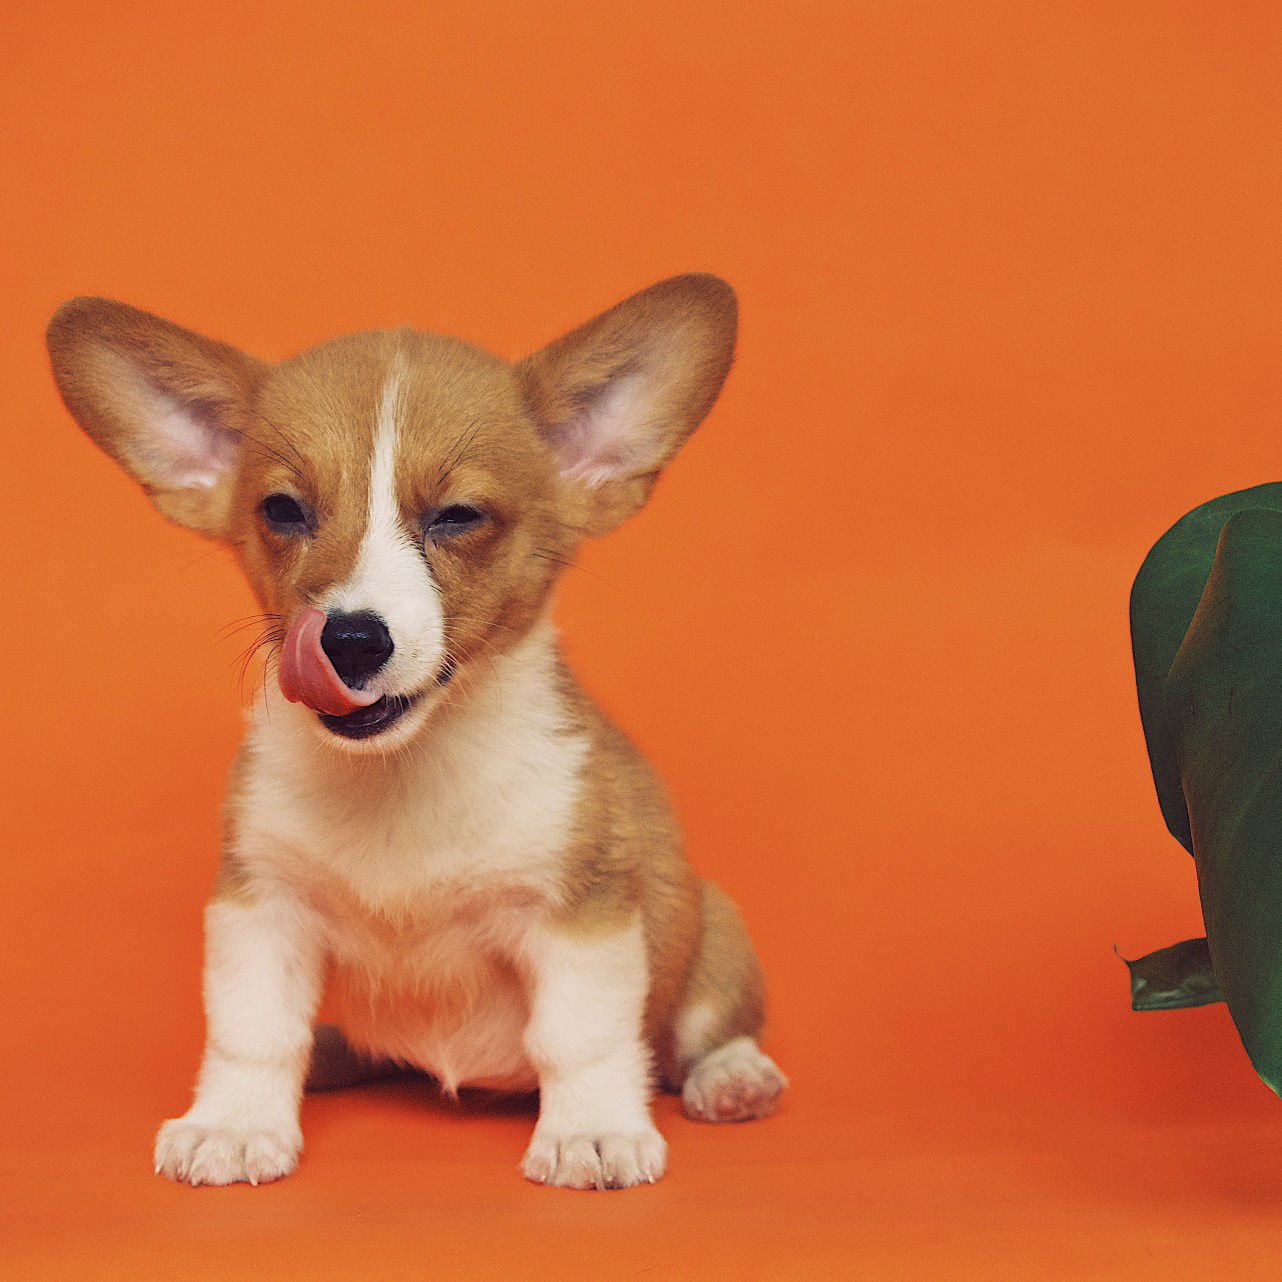

In [24]:
input_images_color[0]

In [ ]:
# mse_loss = nn.MSELoss()

# for epoch in range(1000):
#     fine_tuned_images_id = []
#     fine_tuned_images_pr = []
#     fine_tuned_prompt = 'A sks dog' #Note that sks is our rare token
    
#     fine_tuned_image_id = pipe(prompt=fine_tuned_prompt).images[0]
#     fine_tuned_image_pr = pipe(prompt=prompt).images[0]

#     fine_tuned_image_id = transform(fine_tuned_image_pr)
#     fine_tuned_image_pr = transform(fine_tuned_image_pr)
    
#     fine_tuned_image_id.requires_grad_(True)
#     fine_tuned_image_pr.requires_grad_(True)
    
#     for i in range(5):
#         optimizer.zero_grad()
#         loss_pr = mse_loss(fine_tuned_image_pr, prior_images[i].requires_grad_(True))
#         loss_id = mse_loss(fine_tuned_image_id, input_images[i].requires_grad_(True))
#         loss = loss_pr + loss_id
#         loss.backward()
#         optimizer.step()
#         print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
        
#     if (epoch + 1) % 50 == 0: 
#         torch.save(pipe, 'model' + str(epoch + 1) + '.pth')


        

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def query_model(model, prompt)
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            text_features = text_model.get_text_features(**inputs) #take a look athis
            latent_representation = vae.encode(img) #encoding image to latent representation
        timestep = 0  # Example timestep; you might iterate over timesteps
        noise = torch.randn_like(image_latents) * 0.1  # Small noise
        noisy_image_latents = image_latents + noise
        predicted_noise = diffusion_model(noisy_image_latents, text_features, timestep)
        loss_fn = nn.MSELoss()
        loss = loss_fn(predicted_noise, noise)
    #...then continune with the rest of the training loop. 

        with torch.no_grad():
            reconstructed_img = vae.decode(latent_representation) #decoding from latent represenation to an image
def train_loop(): 
    # mse_loss = nn.MSELoss()

# for epoch in range(1000):
#     fine_tuned_images_id = []
#     fine_tuned_images_pr = []
    fine_tuned_prompt = 'A sks dog' #Note that sks is our rare token
    
#     fine_tuned_image_id = pipe(prompt=fine_tuned_prompt).images[0]
#     fine_tuned_image_pr = pipe(prompt=prompt).images[0]

#     fine_tuned_image_id = transform(fine_tuned_image_pr)
#     fine_tuned_image_pr = transform(fine_tuned_image_pr)
    
#     fine_tuned_image_id.requires_grad_(True)
#     fine_tuned_image_pr.requires_grad_(True)
    

    query_model(pipe, fine_tuned_prompt)
    for i in range(5):
    optimizer.zero_grad()
    loss_pr = mse_loss(fine_tuned_image_pr, prior_images[i].requires_grad_(True))
    loss_id = mse_loss(fine_tuned_image_id, input_images[i].requires_grad_(True))
    loss = loss_pr + loss_id
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
    
    if (epoch + 1) % 50 == 0: 
        torch.save(pipe, 'model' + str(epoch + 1) + '.pth')
    
